In [ ]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [ ]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [ ]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

In [ ]:
X.shape

In [ ]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [ ]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

In [ ]:
bnfeatures.shape

In [ ]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [ ]:
bnfeatures.shape

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

In [16]:
top_model.cv_results_

{'mean_fit_time': array([ 770.85202851,  830.3144978 ,  728.59298801,  730.88507485,
         725.65556092,  758.12087164,  618.57198291,  876.79267004,
         936.01264815, 1047.66710625,  683.22556171,  729.71867993,
         678.66437063,  776.55595987,  706.88217711,  539.17614961,
         258.03980627,  698.32662942,  962.79168217,  962.68993423,
         741.84168835,  688.56352093,  753.53635433,  713.13201678,
         495.18416488,  198.03109746,  144.844909  ,  728.89102914,
         927.2297169 ,  959.53154354,  696.45415635,  737.83796225,
         724.16963096,  495.1851558 ,  201.0570962 ,  107.50535853,
         142.30205042,  692.45506999,  917.18488066,  997.00211771,
         708.14554329,  746.43383069,  479.89107814,  193.6769083 ,
         113.39146574,   96.76273611,  146.73929684,  663.25641248,
         951.61599846,  857.32982304,  727.5138968 ,  411.97176313,
         189.82072065,  103.04884512,   84.05440803,   96.79456334,
         122.55640094,  692.463

In [17]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.33702, std: 0.00260, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.44179, std: 0.00577, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.39108, std: 0.00768, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.22543, std: 0.00608, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.22109, std: 0.00589, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.33652, std: 0.00235, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.01, 'C': 10.0} - score: 0.9392


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


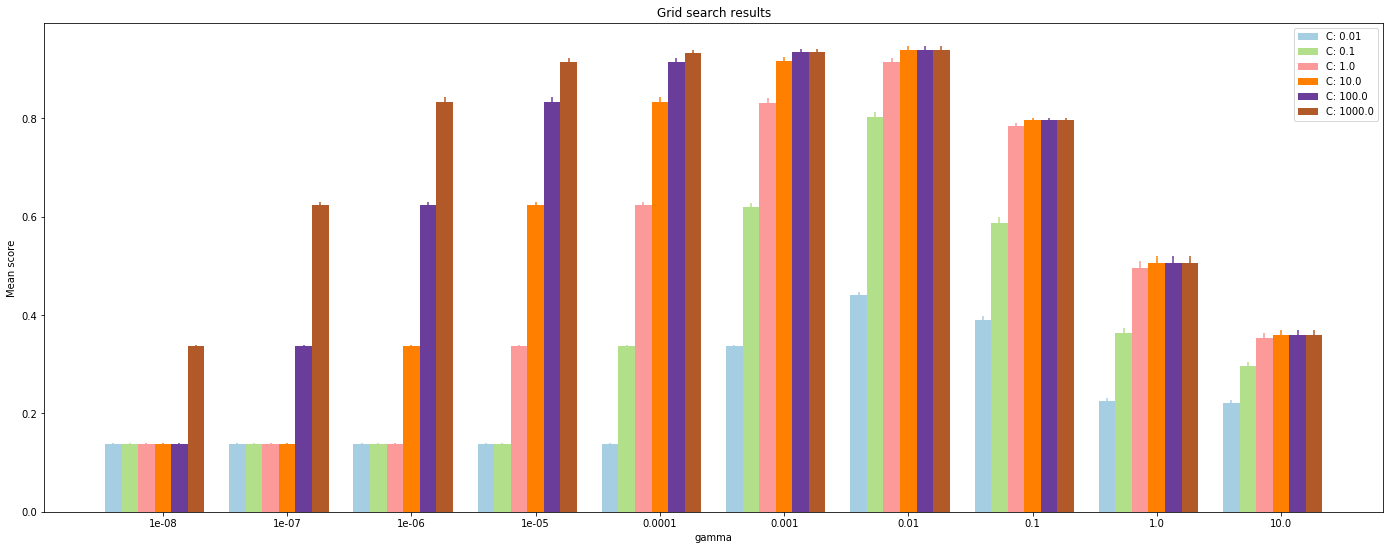

In [19]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()